## California Housing Price
- predict median price per district
- model: regression/labeled supervised learning
- dataset: https://github.com/ageron/handson-ml2/tree/master/datasets/housing

### 1. Read Data

In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [135]:
df=pd.read_csv("california_housing.csv")
df["median_house_value"]/= 1000 #scaling
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452.6,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358.5,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352.1,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341.3,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342.2,NEAR BAY


In [136]:
df.shape

(20640, 10)

In [137]:
df.isna().sum()
#total_badrooms 207/20640 is missing

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [138]:
df=df.dropna()
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### 2. Data Exploration

In [139]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206.864413
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115.435667
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14.999000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119.500000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179.700000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264.700000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500.001000


#### Take away:
- comparing to 75%, max for `total_rooms`, `population`, `households` need a further check.
- abnormal data for target col `median_house_value`.

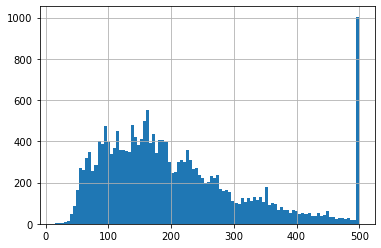

In [140]:
df.median_house_value.hist(bins=100)
#abnormal data here, outlier

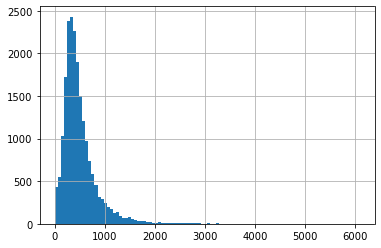

In [141]:
df.households.hist(bins=100)

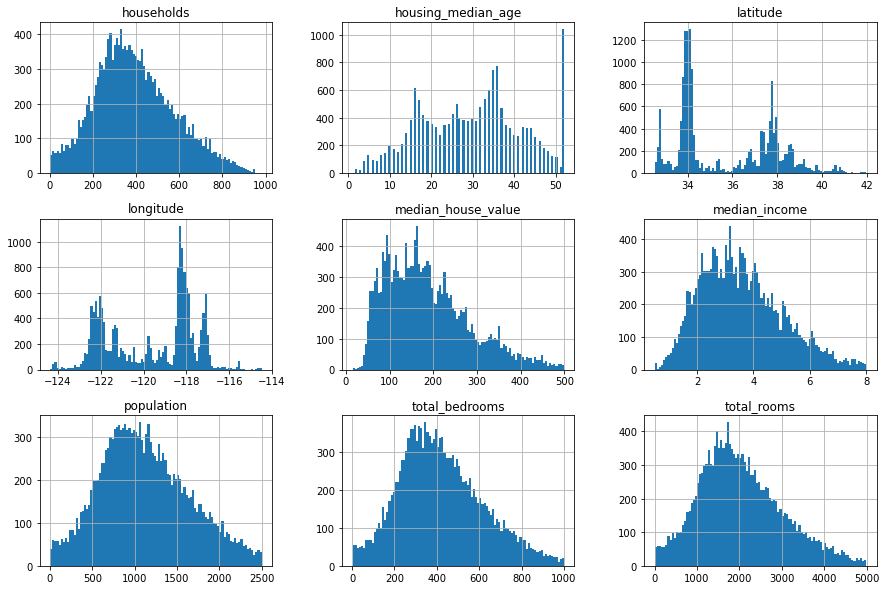

In [142]:
df=df[(df.total_rooms<=5000)&(df.total_bedrooms<=1000)&(df.population<=2500)&(df.households<=1000)&
      (df.median_income<=8)&(df.median_house_value<500)]

#df.median_house_value.hist(bins=100)
#df.total_bedrooms.hist(bins=100)
#df.median_income.hist(bins=100)
#df.total_rooms.hist(bins=100)
#df.population.hist(bins=100)
#df.households.hist(bins=100)
df.hist(bins=100,figsize=(15,10))
plt.show()

In [143]:
df.shape

(16573, 10)

In [144]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352.1,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341.3,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342.2,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269.7,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299.2,NEAR BAY


### 4. Modeling

In [145]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,test_size=0.22, random_state=123)
print("Total sample size = %i\n training sample size = %i \n testing sample size = %i"\
%(df.shape[0],train_df.shape[0],test_df.shape[0]))

Total sample size = 16573
 training sample size = 12926 
 testing sample size = 3647


### 4.1 Define functions that build and train a model
- build_model(learning_rate), which builds a randomly-initialized model.
- train_model(model, feature, label, epochs), which trains the model from the examples (feature and label) you pass.

In [146]:
#Define the functions that build and train a model
def build_model(my_learning_rate):
  # Create and compile a simple linear regression model."""
  model = tf.keras.models.Sequential() # Most simple tf.keras models are sequential.

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Compile the model into TensorFlow.
  # Training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model               

def train_model(model, df, feature, label, my_epochs, 
                my_batch_size=None, my_validation_split=0.1):

  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=my_batch_size,
                      epochs=my_epochs,
                      validation_split=my_validation_split)

  # Gather the model's trained weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the root mean squared error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history   

### 4.2 Define plotting functions
- a scatter plot of the feature vs. the label, and a line showing the output of the trained model
- a loss curve

In [147]:
#Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  # Plot the trained model against 200 random training examples.

  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = train_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. 
  # The red line starts at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 10000
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  plt.show()

#Plot a curve of loss vs. epoch.
def plot_the_loss_curve(epochs, mae_training, mae_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

### 4.3 Call the model functions

Epoch 1/30
104/104 [==============================] - 1s 3ms/step - loss: 38811.9715 - root_mean_squared_error: 196.9474 - val_loss: 28137.0977 - val_root_mean_squared_error: 167.7412
Epoch 2/30
104/104 [==============================] - 0s 1ms/step - loss: 26760.2916 - root_mean_squared_error: 163.4817 - val_loss: 17827.6699 - val_root_mean_squared_error: 133.5203
Epoch 3/30
104/104 [==============================] - 0s 1ms/step - loss: 16737.3907 - root_mean_squared_error: 129.2797 - val_loss: 10622.6963 - val_root_mean_squared_error: 103.0665
Epoch 4/30
104/104 [==============================] - 0s 2ms/step - loss: 9892.1477 - root_mean_squared_error: 99.4133 - val_loss: 6445.3301 - val_root_mean_squared_error: 80.2828
Epoch 5/30
104/104 [==============================] - 0s 2ms/step - loss: 6463.5450 - root_mean_squared_error: 80.3878 - val_loss: 5107.6562 - val_root_mean_squared_error: 71.4679
Epoch 6/30
104/104 [==============================] - 0s 2ms/step - loss: 5580.1147 - ro

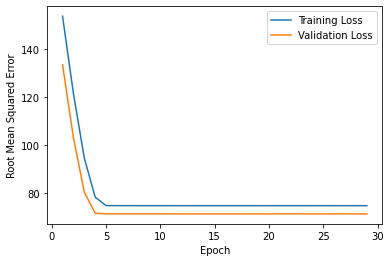

In [148]:
# Hyperparameters:
learning_rate = 0.08
epochs = 30
batch_size = 100

validation_split=0.2

my_feature="median_income" 
my_label="median_house_value"

my_model = None # Discard any pre-existing version of the model.

shuffled_df = train_df.reindex(np.random.permutation(train_df.index))

# Invoke the functions to build and train the model.
my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, shuffled_df, my_feature, 
                                    my_label, epochs, batch_size, 
                                    validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

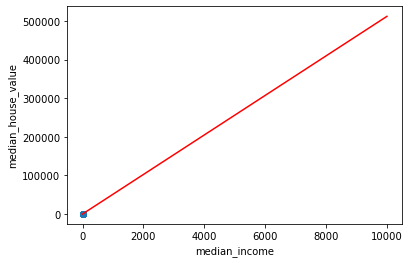

In [150]:
plot_the_model(weight, bias, my_feature, my_label)

In [149]:
x_test = test_df[my_feature]
y_test = test_df[my_label]

results = my_model.evaluate(x_test, y_test, batch_size=batch_size)

37/37 [==============================] - 0s 1ms/step - loss: 5377.5483 - root_mean_squared_error: 73.3318


### 4.4 Make predictions

In [151]:
def predict_house_values(n, feature, label):

  batch = train_df[feature][10000:10000 + n]
  y_predicted= my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (train_df[feature][10000 + i],
                                   train_df[label][10000 + i],
                                   y_predicted[i][0] ))

In [153]:
# invoke the prediction function on 10 examples:
predict_house_values(4, my_feature, my_label)

feature   label          predicted
--------------------------------------
    4    210             307
    4    182             134
    5    206             281
    4    195             237


In [ ]:
# why it stuck at 4 examples?
# features now is one: room_size, how to scale to all features?

In [ ]:
# try binned lat * binned lot * room_size(ttl rooms, ttl bedrooms)